# Uplift Modeling — Lenta Dataset

Training and comparison of uplift models using scikit-uplift + CatBoost.

**Models:**
1. S-Learner (dummy)
2. S-Learner (treatment interaction)
3. T-Learner (vanilla)
4. T-Learner (DDR control)
5. Class Transformation

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load processed data
X_train = pd.read_csv('data/processed/X_train.csv')
X_test = pd.read_csv('data/processed/X_test.csv')
y_train = pd.read_csv('data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('data/processed/y_test.csv').squeeze()
treatment_train = pd.read_csv('data/processed/treatment_train.csv').squeeze()
treatment_test = pd.read_csv('data/processed/treatment_test.csv').squeeze()

# Convert treatment: 'test' -> 1, 'control' -> 0
treatment_train = (treatment_train == 'test').astype(int)
treatment_test = (treatment_test == 'test').astype(int)

# Sanity checks
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'Treatment rate — train: {treatment_train.mean():.3f}, test: {treatment_test.mean():.3f}')
print(f'Conversion rate — train: {y_train.mean():.4f}, test: {y_test.mean():.4f}')
print(f'Treatment dtypes: train={treatment_train.dtype}, test={treatment_test.dtype}')

X_train: (480920, 244), X_test: (206109, 244)
Treatment rate — train: 0.751, test: 0.751
Conversion rate — train: 0.1082, test: 0.1082
Treatment dtypes: train=int64, test=int64


## 2. Fix sklift.viz compatibility

sklearn 1.8 moved `check_matplotlib_support` to `sklearn.utils._plotting`. Patch at runtime.

In [2]:
import sklearn.utils
from sklearn.utils._plotting import check_matplotlib_support
sklearn.utils.check_matplotlib_support = check_matplotlib_support

from sklift.viz import plot_qini_curve, plot_uplift_curve
from sklift.metrics import (
    uplift_at_k, qini_auc_score, uplift_auc_score,
    weighted_average_uplift, qini_curve, uplift_curve,
    perfect_qini_curve, perfect_uplift_curve
)
from sklift.models import SoloModel, TwoModels, ClassTransformation

print('sklift imports OK')

sklift imports OK


## 3. Baseline: Random Model

In [3]:
np.random.seed(42)
uplift_random = np.random.uniform(-0.1, 0.1, size=len(y_test))

print('Random baseline metrics:')
print(f"  uplift@30%: {uplift_at_k(y_test, uplift_random, treatment_test, strategy='by_group', k=0.3):.4f}")
print(f"  Qini AUC:   {qini_auc_score(y_test, uplift_random, treatment_test):.4f}")
print(f"  Uplift AUC: {uplift_auc_score(y_test, uplift_random, treatment_test):.4f}")

Random baseline metrics:
  uplift@30%: 0.0041
  Qini AUC:   -0.0010
  Uplift AUC: -0.0006


## 4. Train Uplift Models

In [4]:
from catboost import CatBoostClassifier

def make_catboost():
    return CatBoostClassifier(
        iterations=200, depth=6, learning_rate=0.1,
        random_state=42, silent=True
    )

models = {}
predictions = {}

### 4.1 S-Learner (dummy)

In [5]:
%%time
sm_dummy = SoloModel(estimator=make_catboost(), method='dummy')
sm_dummy.fit(X_train, y_train, treatment_train)
predictions['S-Learner (dummy)'] = sm_dummy.predict(X_test)
models['S-Learner (dummy)'] = sm_dummy
print('S-Learner (dummy) done')

S-Learner (dummy) done
CPU times: user 1min 30s, sys: 4.9 s, total: 1min 35s
Wall time: 18.2 s


### 4.2 S-Learner (treatment interaction)

In [6]:
%%time
sm_interaction = SoloModel(estimator=make_catboost(), method='treatment_interaction')
sm_interaction.fit(X_train, y_train, treatment_train)
predictions['S-Learner (interaction)'] = sm_interaction.predict(X_test)
models['S-Learner (interaction)'] = sm_interaction
print('S-Learner (interaction) done')

S-Learner (interaction) done
CPU times: user 2min 43s, sys: 5.75 s, total: 2min 49s
Wall time: 29.8 s


### 4.3 T-Learner (vanilla)

In [7]:
%%time
tm_vanilla = TwoModels(
    estimator_trmnt=make_catboost(),
    estimator_ctrl=make_catboost(),
    method='vanilla'
)
tm_vanilla.fit(X_train, y_train, treatment_train)
predictions['T-Learner'] = tm_vanilla.predict(X_test)
models['T-Learner'] = tm_vanilla
print('T-Learner (vanilla) done')

T-Learner (vanilla) done
CPU times: user 1min 50s, sys: 5.59 s, total: 1min 55s
Wall time: 18.8 s


### 4.4 T-Learner (DDR control)

In [8]:
%%time
tm_ddr = TwoModels(
    estimator_trmnt=make_catboost(),
    estimator_ctrl=make_catboost(),
    method='ddr_control'
)
tm_ddr.fit(X_train, y_train, treatment_train)
predictions['T-Learner (DDR)'] = tm_ddr.predict(X_test)
models['T-Learner (DDR)'] = tm_ddr
print('T-Learner (DDR control) done')

T-Learner (DDR control) done
CPU times: user 1min 52s, sys: 6.11 s, total: 1min 58s
Wall time: 19.6 s


### 4.5 Class Transformation

In [9]:
%%time
ct = ClassTransformation(estimator=make_catboost())
ct.fit(X_train, y_train, treatment_train)
predictions['Class Transformation'] = ct.predict(X_test)
models['Class Transformation'] = ct
print('Class Transformation done')

Class Transformation done
CPU times: user 1min 44s, sys: 4.61 s, total: 1min 49s
Wall time: 19.1 s


## 5. Evaluation & Comparison

In [10]:
# Add random baseline to predictions for comparison
all_predictions = {'Random': uplift_random, **predictions}

results = []
for name, uplift_pred in all_predictions.items():
    results.append({
        'Model': name,
        'uplift@10%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.1),
        'uplift@30%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.3),
        'Qini AUC': qini_auc_score(y_test, uplift_pred, treatment_test),
        'Uplift AUC': uplift_auc_score(y_test, uplift_pred, treatment_test),
        'WAU': weighted_average_uplift(y_test, uplift_pred, treatment_test, strategy='by_group', bins=10),
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df.style.format('{:.4f}').highlight_max(axis=0, color='lightgreen')

,uplift@10%,uplift@30%,Qini AUC,Uplift AUC,WAU
Model,,,,,
Random,0.0091,0.0041,-0.0010,-0.0006,0.0076
S-Learner (dummy),0.0220,0.0131,0.0100,0.0055,0.0076
S-Learner (interaction),0.0269,0.0159,0.0148,0.0081,0.0076
T-Learner,0.0165,0.0113,0.0066,0.0036,0.0076
T-Learner (DDR),0.0224,0.0148,0.0144,0.0079,0.0076
Class Transformation,0.1793,0.0308,0.0730,0.0444,0.0076


## 6. Visualization

### 6.0 Distribution of Predicted Probabilities (P(treatment), P(control), Uplift)

Гистограммы условных вероятностей P(Y=1|T=1) и P(Y=1|T=0), а также их разности (uplift) для каждой модели.
Доступно только для S-Learner и T-Learner (ClassTransformation не выдаёт раздельные вероятности).

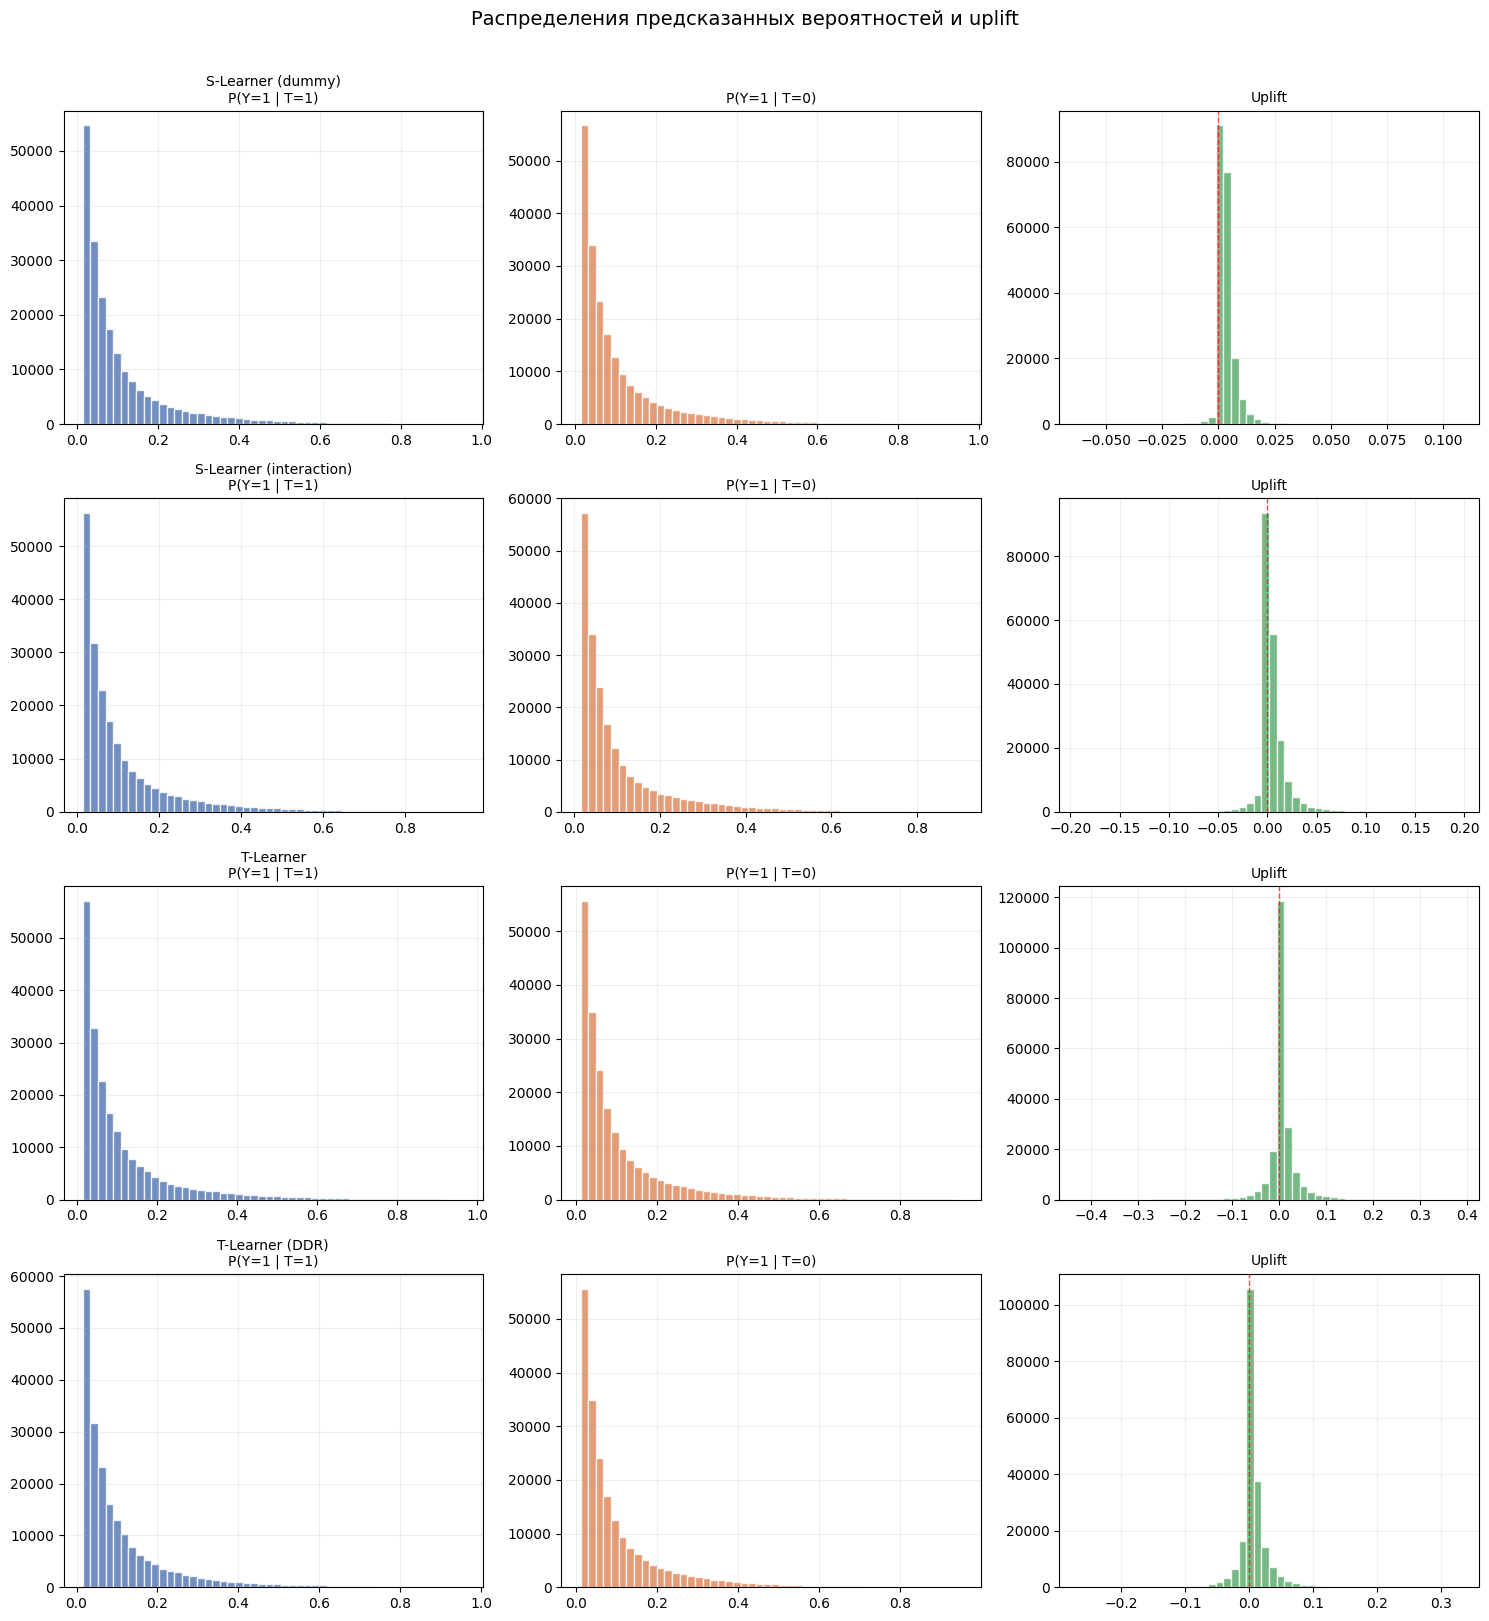

In [11]:
from sklift.viz import plot_uplift_preds

# Models with separate treatment/control predictions
preds_models = {
    'S-Learner (dummy)': models['S-Learner (dummy)'],
    'S-Learner (interaction)': models['S-Learner (interaction)'],
    'T-Learner': models['T-Learner'],
    'T-Learner (DDR)': models['T-Learner (DDR)'],
}

fig, axes = plt.subplots(len(preds_models), 3, figsize=(15, 4 * len(preds_models)))

for row, (name, model) in enumerate(preds_models.items()):
    trmnt_preds = model.trmnt_preds_
    ctrl_preds = model.ctrl_preds_
    uplift_pred = trmnt_preds - ctrl_preds

    for col, (data_arr, title, color) in enumerate([
        (trmnt_preds, 'P(Y=1 | T=1)', '#4C72B0'),
        (ctrl_preds, 'P(Y=1 | T=0)', '#DD8452'),
        (uplift_pred, 'Uplift', '#55A868'),
    ]):
        ax = axes[row, col]
        ax.hist(data_arr, bins=50, color=color, edgecolor='white', alpha=0.8)
        if col == 2:
            ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax.set_title(f'{name}\n{title}' if col == 0 else title, fontsize=10)
        ax.set_xlabel('')
        ax.grid(True, alpha=0.2)

plt.suptitle('Распределения предсказанных вероятностей и uplift', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 6.1 Qini Curves

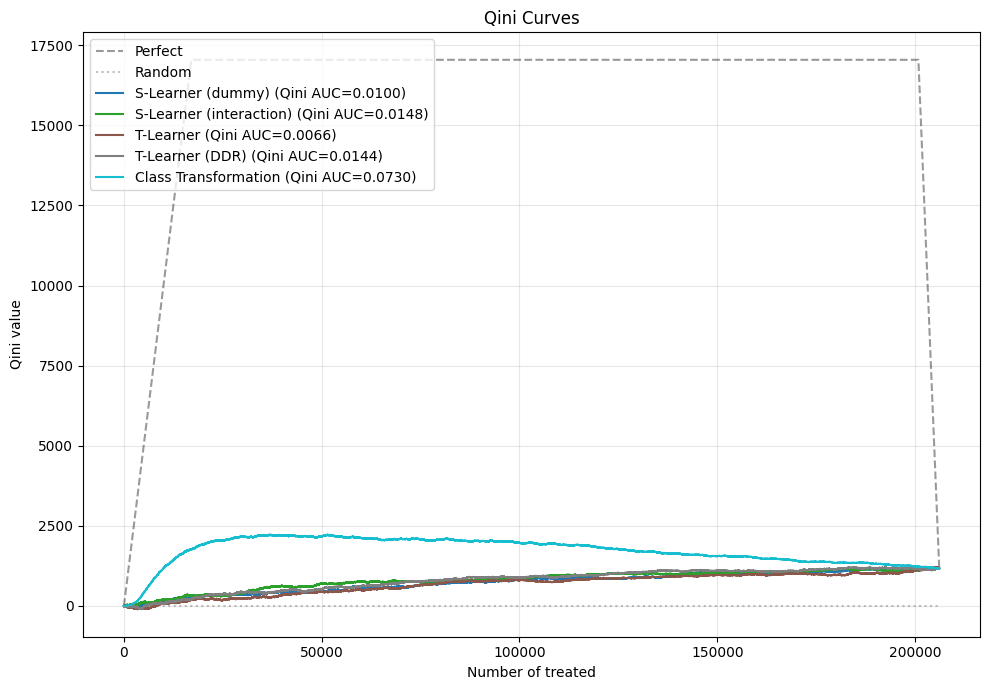

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

# Perfect Qini
x_perf, y_perf = perfect_qini_curve(y_test, treatment_test)
ax.plot(x_perf, y_perf, 'k--', alpha=0.4, label='Perfect')

# Random (diagonal)
ax.plot([0, x_perf[-1]], [0, y_perf[-1] * 0], 'gray', linestyle=':', alpha=0.5, label='Random')

colors = plt.cm.tab10(np.linspace(0, 1, len(predictions)))
for (name, uplift_pred), color in zip(predictions.items(), colors):
    x_vals, y_vals = qini_curve(y_test, uplift_pred, treatment_test)
    auc = qini_auc_score(y_test, uplift_pred, treatment_test)
    ax.plot(x_vals, y_vals, color=color, label=f'{name} (Qini AUC={auc:.4f})')

ax.set_xlabel('Number of treated')
ax.set_ylabel('Qini value')
ax.set_title('Qini Curves')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2 Uplift Curves

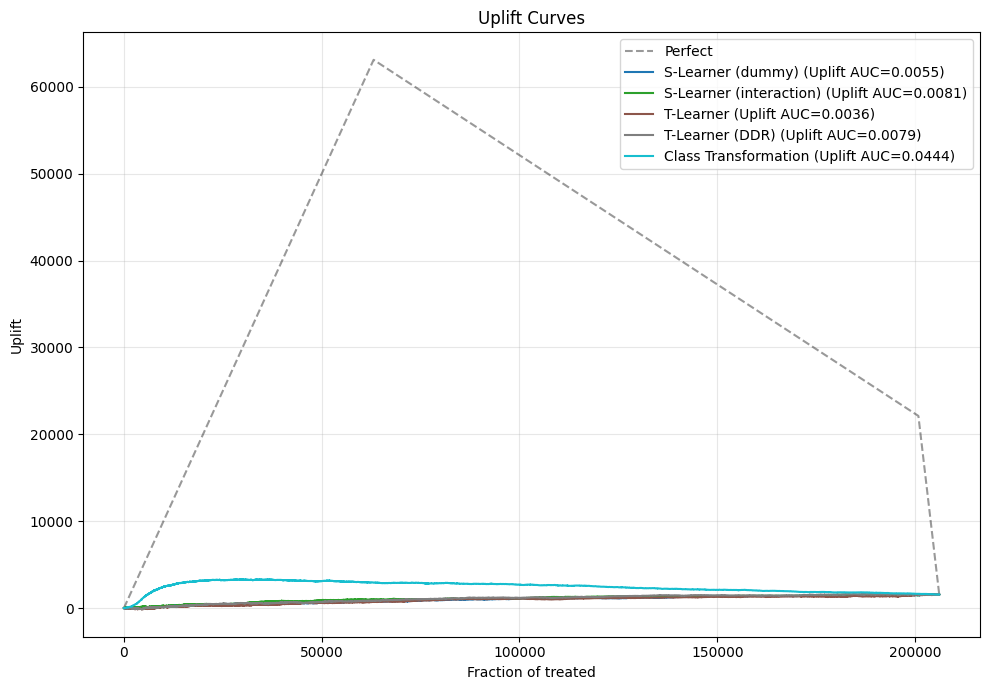

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

# Perfect uplift
x_perf, y_perf = perfect_uplift_curve(y_test, treatment_test)
ax.plot(x_perf, y_perf, 'k--', alpha=0.4, label='Perfect')

colors = plt.cm.tab10(np.linspace(0, 1, len(predictions)))
for (name, uplift_pred), color in zip(predictions.items(), colors):
    x_vals, y_vals = uplift_curve(y_test, uplift_pred, treatment_test)
    auc = uplift_auc_score(y_test, uplift_pred, treatment_test)
    ax.plot(x_vals, y_vals, color=color, label=f'{name} (Uplift AUC={auc:.4f})')

ax.set_xlabel('Fraction of treated')
ax.set_ylabel('Uplift')
ax.set_title('Uplift Curves')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Uplift by Percentile (Best Model)

Best model: Class Transformation


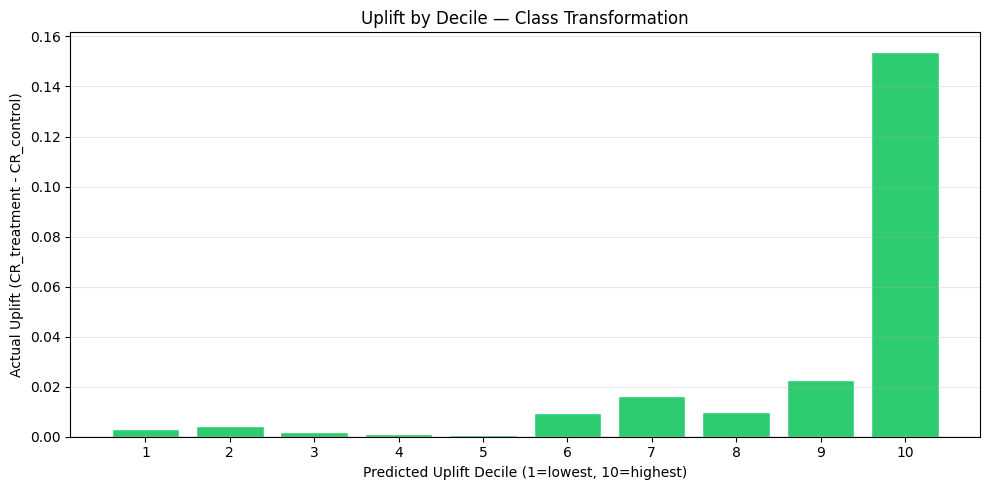

 Decile  CR treatment  CR control   Uplift
      1      0.019852    0.016953 0.002899
      2      0.027780    0.023617 0.004163
      3      0.035077    0.033032 0.002044
      4      0.047378    0.046225 0.001154
      5      0.064933    0.064243 0.000690
      6      0.083540    0.074143 0.009397
      7      0.112903    0.096447 0.016457
      8      0.156915    0.147023 0.009892
      9      0.229613    0.206994 0.022619
     10      0.380376    0.226422 0.153954


In [14]:
# Pick best model by Qini AUC
best_model_name = results_df.drop(index='Random')['Qini AUC'].idxmax()
best_uplift = predictions[best_model_name]
print(f'Best model: {best_model_name}')

# Compute uplift by decile
n_bins = 10
df_eval = pd.DataFrame({
    'uplift_pred': best_uplift,
    'y': y_test.values,
    'treatment': treatment_test.values
})
df_eval['bin'] = pd.qcut(df_eval['uplift_pred'], n_bins, labels=False, duplicates='drop')

bin_stats = []
for b in sorted(df_eval['bin'].unique()):
    subset = df_eval[df_eval['bin'] == b]
    cr_t = subset.loc[subset['treatment'] == 1, 'y'].mean()
    cr_c = subset.loc[subset['treatment'] == 0, 'y'].mean()
    bin_stats.append({'Decile': b + 1, 'CR treatment': cr_t, 'CR control': cr_c, 'Uplift': cr_t - cr_c})

bin_df = pd.DataFrame(bin_stats)

fig, ax = plt.subplots(figsize=(10, 5))
colors_bar = ['#2ecc71' if u > 0 else '#e74c3c' for u in bin_df['Uplift']]
ax.bar(bin_df['Decile'], bin_df['Uplift'], color=colors_bar, edgecolor='white')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_xlabel('Predicted Uplift Decile (1=lowest, 10=highest)')
ax.set_ylabel('Actual Uplift (CR_treatment - CR_control)')
ax.set_title(f'Uplift by Decile — {best_model_name}')
ax.set_xticks(bin_df['Decile'])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(bin_df.to_string(index=False))

### 6.4 Distribution of Predicted Uplift (Best Model)

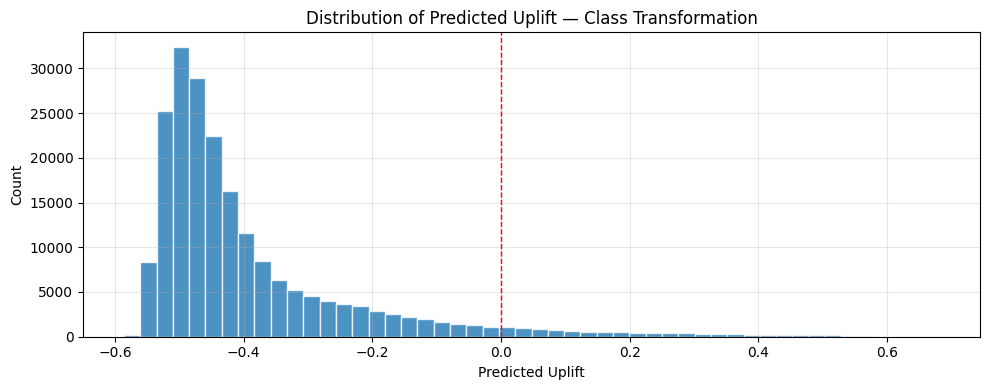

Mean: -0.3883, Std: 0.1758
Min: -0.5859, Max: 0.6813
% positive uplift: 4.8%


In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(best_uplift, bins=50, edgecolor='white', alpha=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Uplift')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Predicted Uplift — {best_model_name}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Mean: {best_uplift.mean():.4f}, Std: {best_uplift.std():.4f}')
print(f'Min: {best_uplift.min():.4f}, Max: {best_uplift.max():.4f}')
print(f'% positive uplift: {(best_uplift > 0).mean():.1%}')

## 7. Feature Importance (Best Model)

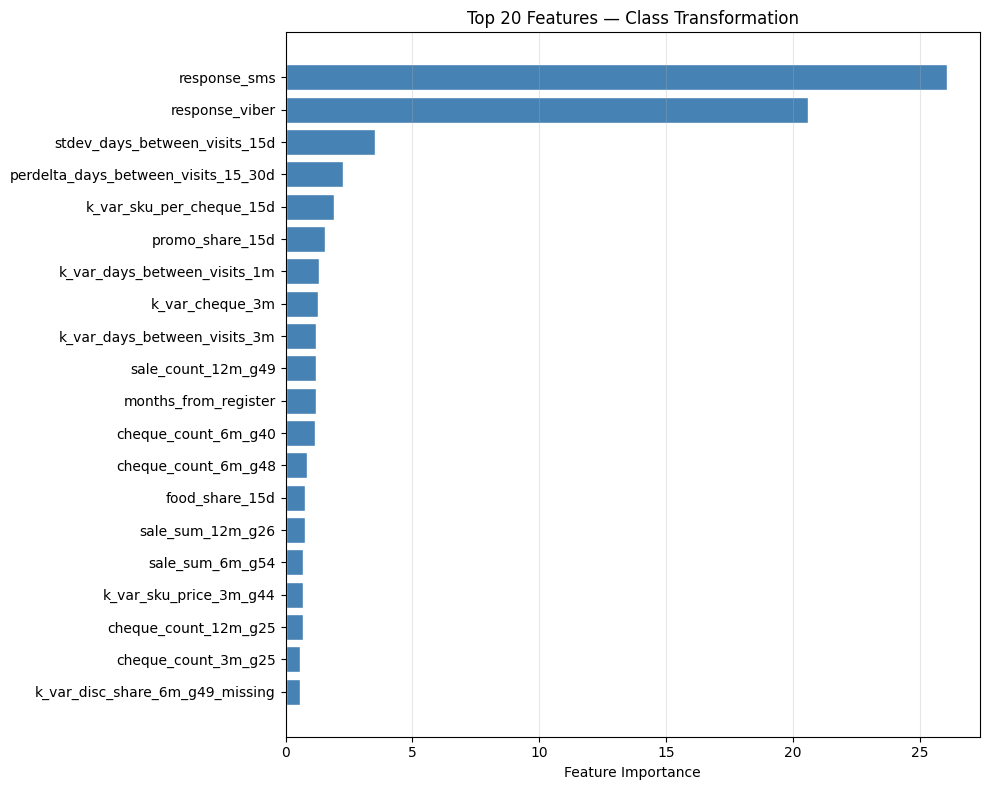

In [16]:
# Extract CatBoost estimator from the best model
best_sklift_model = models[best_model_name]

# Get the underlying CatBoost estimator(s)
if hasattr(best_sklift_model, 'estimator'):
    # SoloModel or ClassTransformation
    cb_model = best_sklift_model.estimator
    feature_names = X_train.columns.tolist()
    # SoloModel with treatment_interaction adds extra features
    if hasattr(cb_model, 'feature_names_') and cb_model.feature_names_:
        feature_names = list(cb_model.feature_names_)
    importances = cb_model.feature_importances_
elif hasattr(best_sklift_model, 'estimator_trmnt'):
    # TwoModels — average importances from both models
    cb_trmnt = best_sklift_model.estimator_trmnt
    cb_ctrl = best_sklift_model.estimator_ctrl
    feature_names = X_train.columns.tolist()
    importances = (cb_trmnt.feature_importances_ + cb_ctrl.feature_importances_) / 2

# Top 20
top_n = 20
idx = np.argsort(importances)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), importances[idx], color='steelblue', edgecolor='white')
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_names[i] for i in idx])
ax.set_xlabel('Feature Importance')
ax.set_title(f'Top {top_n} Features — {best_model_name}')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [17]:
# Check if EDA-identified effect modifiers rank high
effect_modifiers = ['age', 'gender', 'response_sms', 'response_viber', 'main_format']
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
fi_df['rank'] = fi_df.index + 1

print('EDA-identified effect modifiers ranking:')
for feat in effect_modifiers:
    matches = fi_df[fi_df['feature'].str.contains(feat, case=False)]
    if len(matches) > 0:
        for _, row in matches.iterrows():
            print(f"  {row['feature']:30s} — rank {row['rank']:3d}, importance {row['importance']:.2f}")
    else:
        print(f"  {feat:30s} — not found in features")

EDA-identified effect modifiers ranking:
  age                            — rank  22, importance 0.56
  gender                         — rank  31, importance 0.45
  response_sms                   — rank   1, importance 26.07
  response_viber                 — rank   2, importance 20.59
  main_format                    — rank  51, importance 0.34


## 8. Улучшение лучшей модели (Class Transformation)

Baseline: `CatBoostClassifier(iterations=200, depth=6, lr=0.1)` → **Qini AUC = 0.0730**

Направления:
1. Больше итераций (200 → 500, 1000)
2. Ниже learning rate + больше итераций
3. Глубина деревьев и регуляризация
4. ClassTransformationReg (регрессионный вариант)
5. LightGBM как base learner

In [18]:
import time
from sklift.models import ClassTransformationReg
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

def evaluate_model(name, uplift_pred):
    """Compute all uplift metrics for a model."""
    return {
        'Model': name,
        'uplift@10%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.1),
        'uplift@30%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.3),
        'Qini AUC': qini_auc_score(y_test, uplift_pred, treatment_test),
        'Uplift AUC': uplift_auc_score(y_test, uplift_pred, treatment_test),
    }

tuning_results = []

# Baseline (already computed)
tuning_results.append(evaluate_model('Baseline (iter=200, lr=0.1, d=6)', predictions['Class Transformation']))
print('Baseline added')

Baseline added


### 8.1. Эффект числа итераций

In [19]:
for n_iter in [300, 500]:
    t0 = time.time()
    cb = CatBoostClassifier(iterations=n_iter, depth=6, learning_rate=0.1, random_state=42, silent=True)
    ct = ClassTransformation(estimator=cb)
    ct.fit(X_train, y_train, treatment_train)
    pred = ct.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT iter={n_iter}, lr=0.1, d=6'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT iter=300, lr=0.1, d=6: Qini AUC=0.0739, uplift@10%=0.1792 (46.3s)


CT iter=500, lr=0.1, d=6: Qini AUC=0.0731, uplift@10%=0.1727 (42.8s)


### 8.2. Learning rate tuning

In [20]:
lr_configs = [
    {'iterations': 500, 'learning_rate': 0.05, 'depth': 6},
    {'iterations': 700, 'learning_rate': 0.03, 'depth': 6},
]

for cfg in lr_configs:
    t0 = time.time()
    cb = CatBoostClassifier(**cfg, random_state=42, silent=True)
    ct = ClassTransformation(estimator=cb)
    ct.fit(X_train, y_train, treatment_train)
    pred = ct.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT iter={cfg["iterations"]}, lr={cfg["learning_rate"]}, d={cfg["depth"]}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT iter=500, lr=0.05, d=6: Qini AUC=0.0741, uplift@10%=0.1722 (44.6s)


CT iter=700, lr=0.03, d=6: Qini AUC=0.0734, uplift@10%=0.1753 (64.3s)


### 8.3. Глубина деревьев и регуляризация

In [21]:
depth_reg_configs = [
    {'depth': 4, 'l2_leaf_reg': 3},
    {'depth': 7, 'l2_leaf_reg': 3},
    {'depth': 6, 'l2_leaf_reg': 1},
    {'depth': 6, 'l2_leaf_reg': 10},
]

base_iter, base_lr = 500, 0.05

for cfg in depth_reg_configs:
    t0 = time.time()
    cb = CatBoostClassifier(
        iterations=base_iter, learning_rate=base_lr,
        depth=cfg['depth'], l2_leaf_reg=cfg['l2_leaf_reg'],
        random_state=42, silent=True
    )
    ct = ClassTransformation(estimator=cb)
    ct.fit(X_train, y_train, treatment_train)
    pred = ct.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT d={cfg["depth"]}, l2={cfg["l2_leaf_reg"]}, iter={base_iter}, lr={base_lr}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT d=4, l2=3, iter=500, lr=0.05: Qini AUC=0.0728, uplift@10%=0.1577 (39.1s)


CT d=7, l2=3, iter=500, lr=0.05: Qini AUC=0.0736, uplift@10%=0.1701 (55.6s)


CT d=6, l2=1, iter=500, lr=0.05: Qini AUC=0.0733, uplift@10%=0.1744 (48.4s)


CT d=6, l2=10, iter=500, lr=0.05: Qini AUC=0.0738, uplift@10%=0.1717 (48.6s)


### 8.4. ClassTransformationReg (регрессионный вариант)

In [22]:
ct_reg_configs = [
    {'iterations': 500, 'learning_rate': 0.05, 'depth': 6},
    {'iterations': 500, 'learning_rate': 0.05, 'depth': 4},
]

propensity = treatment_train.mean()  # 0.751

for cfg in ct_reg_configs:
    t0 = time.time()
    reg = CatBoostRegressor(**cfg, random_state=42, silent=True)
    ct_reg = ClassTransformationReg(estimator=reg, propensity_val=propensity)
    ct_reg.fit(X_train, y_train, treatment_train)
    pred = ct_reg.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT-Reg d={cfg["depth"]}, iter={cfg["iterations"]}, lr={cfg["learning_rate"]}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT-Reg d=6, iter=500, lr=0.05: Qini AUC=0.0000, uplift@10%=0.0142 (31.1s)


CT-Reg d=4, iter=500, lr=0.05: Qini AUC=0.0027, uplift@10%=0.0196 (25.2s)


### 8.5. LightGBM как base learner

In [23]:
lgb_configs = [
    {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 31},
    {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 15},
]

for cfg in lgb_configs:
    t0 = time.time()
    lgb = LGBMClassifier(**cfg, random_state=42, verbose=-1)
    ct_lgb = ClassTransformation(estimator=lgb)
    ct_lgb.fit(X_train, y_train, treatment_train)
    pred = ct_lgb.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT-LGB d={cfg["max_depth"]}, leaves={cfg["num_leaves"]}, iter={cfg["n_estimators"]}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

# ClassTransformationReg + LGBMRegressor
t0 = time.time()
lgb_reg = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, num_leaves=31, random_state=42, verbose=-1)
ct_lgb_reg = ClassTransformationReg(estimator=lgb_reg, propensity_val=propensity)
ct_lgb_reg.fit(X_train, y_train, treatment_train)
pred = ct_lgb_reg.predict(X_test)
elapsed = time.time() - t0

name = 'CT-Reg-LGB d=6, leaves=31, iter=500'
res = evaluate_model(name, pred)
tuning_results.append(res)
print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT-LGB d=6, leaves=31, iter=500: Qini AUC=0.0752, uplift@10%=0.1790 (17.7s)


CT-LGB d=4, leaves=15, iter=500: Qini AUC=0.0743, uplift@10%=0.1631 (15.3s)


CT-Reg-LGB d=6, leaves=31, iter=500: Qini AUC=-0.0042, uplift@10%=0.0205 (14.4s)


### 8.6. Итоговая сводка

In [24]:
tuning_df = pd.DataFrame(tuning_results).set_index('Model')
tuning_df = tuning_df.sort_values('Qini AUC', ascending=False)

print('=== Все конфигурации (отсортированы по Qini AUC) ===\n')
print(tuning_df.to_string(float_format='{:.4f}'.format))
print(f'\nBaseline Qini AUC: 0.0730')
print(f'Best Qini AUC: {tuning_df["Qini AUC"].max():.4f} ({tuning_df["Qini AUC"].idxmax()})')

tuning_df.style.format('{:.4f}').highlight_max(axis=0, color='lightgreen')

=== Все конфигурации (отсортированы по Qini AUC) ===

                                     uplift@10%  uplift@30%  Qini AUC  Uplift AUC
Model                                                                            
CT-LGB d=6, leaves=31, iter=500          0.1790      0.0327    0.0752      0.0457
CT-LGB d=4, leaves=15, iter=500          0.1631      0.0305    0.0743      0.0451
CT iter=500, lr=0.05, d=6                0.1722      0.0314    0.0741      0.0450
CT iter=300, lr=0.1, d=6                 0.1792      0.0326    0.0739      0.0449
CT d=6, l2=10, iter=500, lr=0.05         0.1717      0.0314    0.0738      0.0449
CT d=7, l2=3, iter=500, lr=0.05          0.1701      0.0324    0.0736      0.0447
CT iter=700, lr=0.03, d=6                0.1753      0.0316    0.0734      0.0446
CT d=6, l2=1, iter=500, lr=0.05          0.1744      0.0319    0.0733      0.0446
CT iter=500, lr=0.1, d=6                 0.1727      0.0321    0.0731      0.0444
Baseline (iter=200, lr=0.1, d=6)         0.1

,uplift@10%,uplift@30%,Qini AUC,Uplift AUC
Model,,,,
"CT-LGB d=6, leaves=31, iter=500",0.1790,0.0327,0.0752,0.0457
"CT-LGB d=4, leaves=15, iter=500",0.1631,0.0305,0.0743,0.0451
"CT iter=500, lr=0.05, d=6",0.1722,0.0314,0.0741,0.0450
"CT iter=300, lr=0.1, d=6",0.1792,0.0326,0.0739,0.0449
"CT d=6, l2=10, iter=500, lr=0.05",0.1717,0.0314,0.0738,0.0449
"CT d=7, l2=3, iter=500, lr=0.05",0.1701,0.0324,0.0736,0.0447
"CT iter=700, lr=0.03, d=6",0.1753,0.0316,0.0734,0.0446
"CT d=6, l2=1, iter=500, lr=0.05",0.1744,0.0319,0.0733,0.0446
"CT iter=500, lr=0.1, d=6",0.1727,0.0321,0.0731,0.0444


In [25]:
# Re-train best config to get predictions for plots
best_row = tuning_df['Qini AUC'].idxmax()
print(f'Best model: {best_row}')
print(f'Qini AUC improvement: {tuning_df["Qini AUC"].max():.4f} vs 0.0730 (baseline)')
improvement_pct = (tuning_df["Qini AUC"].max() - 0.0730) / 0.0730 * 100
print(f'Relative improvement: {improvement_pct:+.1f}%')

Best model: CT-LGB d=6, leaves=31, iter=500
Qini AUC improvement: 0.0752 vs 0.0730 (baseline)
Relative improvement: +3.1%
